## Here I examine how many steps are necessary for the charge basis discretization.
## And how many steps are needed for the Trotter approximation.

In [1]:
import torch as t
import matplotlib.pyplot as plt

In [4]:
EJ = 2*t.pi*10
EC = EJ/400
phi_ext = 0.001*t.pi

In [39]:
def NCharge_search(steps=40,N_max=1001):
    Ns = t.arange(11,11+1*steps,1)
    eigvals = t.zeros(Ns.shape[0],11)
    for i, N in enumerate(Ns):
        q = t.linspace(-(N - 1)//2,N//2,N)
        q_mat = t.diag(q)
        KinE = 4*EC*q_mat**2

        cos_mat = (t.diag(t.ones(N-1),-1) + t.diag(t.ones(N-1),1)).type(t.complex128)
        cos2_mat = (t.diag(t.ones(N-2,dtype=t.complex128),-2)*t.exp(t.tensor(-1j*phi_ext)) + t.diag(t.ones(N-2),2)*t.exp(t.tensor(1j*phi_ext)))
        PotE = -EJ*cos_mat + EJ/2*cos2_mat
        eigvals[i] = t.linalg.eigvalsh(KinE + PotE)[:11]
    N = N_max
    q = t.linspace(-(N - 1)//2,N//2,N)
    q_mat = t.diag(q)
    KinE = 4*EC*q_mat**2

    cos_mat = (t.diag(t.ones(N-1),-1) + t.diag(t.ones(N-1),1)).type(t.complex128)
    cos2_mat = (t.diag(t.ones(N-2,dtype=t.complex128),-2)*t.exp(t.tensor(-1j*phi_ext)) + t.diag(t.ones(N-2),2)*t.exp(t.tensor(1j*phi_ext)))
    PotE = -EJ*cos_mat + EJ/2*cos2_mat
    return eigvals - t.linalg.eigvalsh(KinE + PotE)[:11], Ns

errs, Ns = NCharge_search(100,5001)

C:\Users\jv97\AppData\Local\Temp/ipykernel_12500/1816737844.py:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  q = t.linspace(-(N - 1)//2,N//2,N)


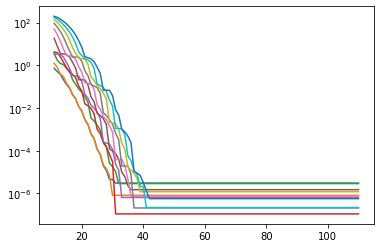

In [40]:
fig, ax = plt.subplots()

ax.plot(Ns,errs.abs());
ax.set_yscale('log')

In [52]:
list(range(10,5000,5000//10))

[10, 510, 1010, 1510, 2010, 2510, 3010, 3510, 4010, 4510]

In [87]:
def NTrotter_search(N=51,T=30,steps=10,Nt_max=5000):
    q = t.linspace(-(N - 1)//2,N//2,N)
    q_mat = t.diag(q)
    KinE = 4*EC*q_mat**2

    cos_mat = (t.diag(t.ones(N-1),-1) + t.diag(t.ones(N-1),1)).type(t.complex128)
    cos2_mat = (t.diag(t.ones(N-2,dtype=t.complex128),-2)*t.exp(t.tensor(-1j*phi_ext)) + t.diag(t.ones(N-2),2)*t.exp(t.tensor(1j*phi_ext)))
    PotE = -EJ*cos_mat + EJ/2*cos2_mat
    H = KinE + PotE

    Nts = list(range(0,Nt_max,Nt_max//steps))
    Us = t.zeros((len(Nts),N,N),dtype=t.complex128)
    for i, Nt in enumerate(Nts):
        times = t.linspace(0,T,Nt)
        dt = (times[1:] - times[:-1]).mean().item()
        Us[i] = t.matrix_power(t.matrix_exp(-1j*H*dt),Nt)
    
    errs = t.zeros(len(Nts))
    target_adj = t.matrix_exp(-1j*H*T)#Us[-1].adjoint()[:4,:4]
    for i, U in enumerate(Us):
        errs[i] = 1 - 1/N**2*t.square(t.abs(t.trace(t.mm(target_adj,U))))
    return errs, Nts
Trot_errs, Nts = NTrotter_search(T=30,steps=10,Nt_max=10)
    

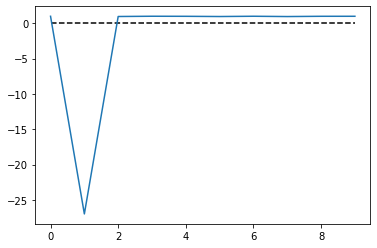

In [88]:
fig, ax = plt.subplots()
ax.plot(Nts,Trot_errs)
ax.hlines(0,min(Nts),max(Nts),'k',linestyle='--')
# ax.set_ylim(0,0.05)
# ax.set_yscale('log')